# Combining InSAR Data From Different Tracks and Orbits

## Setup

In [1]:
%matplotlib inline
import glob
import numpy as np
import sys
import shutil
from itertools import product
from pathlib import Path
from skimage import morphology

import os
import matplotlib.pyplot as plt
from mintpy.utils import readfile, writefile, utils as ut
from mintpy import workflow, view, tsview, plot_network, plot_transection, plot_coherence_matrix

In [2]:
cd ~/data/combined

/home/micromamba/data/combined


In [5]:
tracks = ['asc','desc']
years = [2019,2020,2021]

## Set paths

In [3]:
data_paths = {'asc_lower':Path('../asc_lower').resolve(),
             'asc_upper':Path('../asc_upper').resolve(),
             'desc_lower':Path('../desc_lower').resolve(),
             'desc_upper':Path('../desc_upper').resolve()}

## Create eroded mask file and mask velocity datasets

In [64]:
for name in data_paths:
    p = data_paths[name]

    mask_name = f'maskTempCoh_{name.replace("_","")}_erd.h5'
    
    # Find files
    vels = list(p.glob('velocity*h5'))
    tcoh_mask = list(p.glob('maskTempCoh_*h5'))[0]

    # Create new mask
    data, atr = readfile.read(tcoh_mask)
    erd = (morphology.binary_erosion(morphology.remove_small_holes(data,10), morphology.square(51))).astype(int)
    writefile.write({'mask':erd},mask_name,ref_file=tcoh_mask)
    
    # Mask velocity files
    for v in vels:
        name, ext = v.name.split('.')
        vel_name = f'{name}_mask.{ext}'
        !mask.py {str(v)} -m {mask_name} -o {vel_name}


delete exsited file: maskTempCoh_asclower_erd.h5
create HDF5 file: maskTempCoh_asclower_erd.h5 with w mode
create dataset /mask of int64      in size of (2394, 4120)         with compression=None
finished writing to maskTempCoh_asclower_erd.h5
masking velocity    from /home/micromamba/insar/asc_lower/velocity_asclower_2020.h5 ...
masking velocityStd from /home/micromamba/insar/asc_lower/velocity_asclower_2020.h5 ...
delete exsited file: velocity_asclower_2020_mask.h5
create HDF5 file: velocity_asclower_2020_mask.h5 with w mode
create dataset /velocity    of float32    in size of (2394, 4120)         with compression=None
create dataset /velocityStd of float32    in size of (2394, 4120)         with compression=None
finished writing to velocity_asclower_2020_mask.h5
Done.
masking velocity    from /home/micromamba/insar/asc_lower/velocity_asclower_2019.h5 ...
masking velocityStd from /home/micromamba/insar/asc_lower/velocity_asclower_2019.h5 ...
delete exsited file: velocity_asclower_201

## Merge ascending and descending velocity by year

In [19]:
for track, year in product(tracks,years):
    vel_pattern = f'velocity_{track}*_{year}_mask.h5'
    vel_name = f'velocity_{track}_{year}.h5'
    std_name = f'std_{track}_{year}.h5'
    
    # temp_cohs = Path('..').glob(f'*/temporalCoherence_{track}*{year}.h5')
    # temp_cohs = ' '.join([str(x.resolve()) for x in temp_cohs])
    # temp_coh_name = f'temporalCoherence_{track}_{year}.h5'

    # plotting results needs to be disabled at line 279 of image_stitch.py
    !image_stitch.py {vel_pattern} -o {vel_name} -d velocity --no-offset
    !image_stitch.py {vel_pattern} -o {std_name} -d velocityStd --no-offset
    # !image_stitch.py {temp_cohs} -o {temp_coh_name} --no-offset

files to be stitched:
	/home/micromamba/data/asc_lower/temporalCoherence_asclower_2019.h5
	/home/micromamba/data/asc_upper/temporalCoherence_ascupper_2019.h5
read data from file: /home/micromamba/data/asc_lower/temporalCoherence_asclower_2019.h5
--------------------------------------------------
read data from file: /home/micromamba/data/asc_upper/temporalCoherence_ascupper_2019.h5
stitching ...
grab corners of input matrices
calculate corners of output matrix
estimate difference in the overlaping area
create output metadata and matrix in shape of (2572, 4782)
--------------------------------------------------
create HDF5 file: temporalCoherence_asc_2019.h5 with w mode
create dataset /temporalCoherence of float32    in size of (2572, 4782)         with compression=None
finished writing to temporalCoherence_asc_2019.h5
files to be stitched:
	/home/micromamba/data/asc_lower/temporalCoherence_asclower_2020.h5
	/home/micromamba/data/asc_upper/temporalCoherence_ascupper_2020.h5
read data fr

## Project from ascending/descending orbit to E-W/Up-Down

In [104]:
for year in years:
    asc_vel = f'velocity_asc_{year}.h5'
    desc_vel = f'velocity_desc_{year}.h5'
    
    asc_std = f'std_asc_{year}.h5'
    desc_std = f'std_desc_{year}.h5'
    
    up_vel = f'velocity_up_{year}.h5'
    ew_vel = f'velocity_ew_{year}.h5'

    up_std = f'std_up_{year}.h5'    
    ew_std = f'std_ew_{year}.h5'

    !asc_desc2horz_vert.py {asc_vel} {desc_vel} -o {ew_vel} {up_vel} --max-ref-yx-diff 10000
    !asc_desc2horz_vert.py {asc_std} {desc_std} -o {ew_std} {up_std} --max-ref-yx-diff 10000

---------------------
common area in SNWE: (5550080.0, 5652960.0, 271360.0, 462640.0)
read from file: velocity_asc_2019.h5
read from file: velocity_desc_2019.h5
---------------------
get design matrix
LOS incidence angle: 35.66832225719844 deg
LOS azimuth angle: 103.83512539999998 deg
LOS incidence angle: 35.77095461818939 deg
LOS azimuth angle: -103.77717740000003 deg
project asc/desc into horz/vert direction
---------------------
writing horizontal component to file: velocity_ew_2019.h5
create HDF5 file: velocity_ew_2019.h5 with w mode
create dataset /velocity of float32    in size of (2572, 4782)         with compression=None
finished writing to velocity_ew_2019.h5
writing   vertical component to file: velocity_up_2019.h5
create HDF5 file: velocity_up_2019.h5 with w mode
create dataset /velocity of float32    in size of (2572, 4782)         with compression=None
finished writing to velocity_up_2019.h5
Done.
---------------------
common area in SNWE: (5550080.0, 5652960.0, 271360.0, 

## Prep temporal coherence

In [109]:
for track, year in product(tracks,years):

    pattern = f'../{track}*/temporalCoherence_{track}*_{year}.h5'
    coh_name = f'temporalCoherence_{track}_{year}.h5'
    image1, image2 = [x.resolve() for x in Path().glob(pattern)]
    
    image1_mask = f'maskTempCoh_{image1.name.split("_")[1]}_erd.h5'
    image2_mask = f'maskTempCoh_{image2.name.split("_")[1]}_erd.h5'
    
    !mask.py {str(image1)} -m {str(image1_mask)} -o image1.h5
    !mask.py {str(image2)} -m {str(image2_mask)} -o image2.h5

    # plotting results needs to be disabled at line 279 of image_stitch.py
    !image_stitch.py image1.h5 image2.h5 -o {coh_name} --no-offset

masking temporalCoherence from /home/micromamba/data/asc_lower/temporalCoherence_asclower_2019.h5 ...
delete exsited file: image1.h5
create HDF5 file: image1.h5 with w mode
create dataset /temporalCoherence of float32    in size of (2394, 4120)         with compression=None
finished writing to image1.h5
Done.
masking temporalCoherence from /home/micromamba/data/asc_upper/temporalCoherence_ascupper_2019.h5 ...
delete exsited file: image2.h5
create HDF5 file: image2.h5 with w mode
create dataset /temporalCoherence of float32    in size of (2549, 4782)         with compression=None
finished writing to image2.h5
Done.
files to be stitched:
	image1.h5
	image2.h5
read data from file: image1.h5
--------------------------------------------------
read data from file: image2.h5
stitching ...
grab corners of input matrices
calculate corners of output matrix
estimate difference in the overlaping area
create output metadata and matrix in shape of (2572, 4782)
---------------------------------------

In [110]:
!rm image1.h5 image2.h5

view.py temporalCoherence_avg_2019.h5 --noverbose


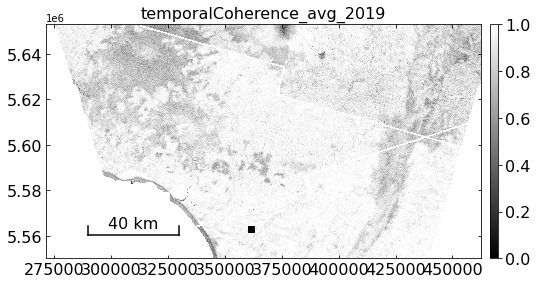

In [22]:
view.main('temporalCoherence_avg_2019.h5 --noverbose'.split(' '))

view.py mask.h5 --noverbose


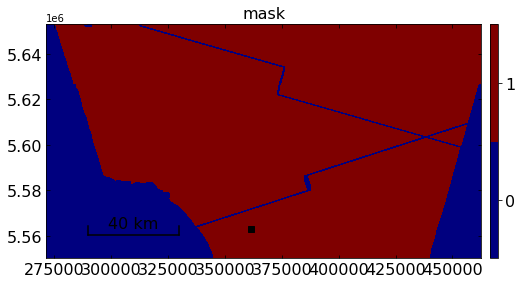

In [20]:
view.main('mask.h5 --noverbose'.split(' '))

In [11]:
!generate_mask.py temporalCoherence_asc_2019.h5 -m 0 -o test.h5

input temporalCoherence file: temporalCoherence_asc_2019.h5
read temporalCoherence_asc_2019.h5
create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels with value < 0.0
create HDF5 file: test.h5 with w mode
create dataset /mask of bool       in size of (2572, 4782)         with compression=None
finished writing to test.h5
time used: 00 mins 0.8 secs.


In [23]:
for year in years:
    image1, image2 = f'temporalCoherence_asc_{year}.h5 temporalCoherence_desc_{year}.h5'.split(' ')
    out_name = f'temporalCoherence_avg_{year}.h5'

    !generate_mask.py {str(image1)} -m 0 -o image1_mask.h5
    !generate_mask.py {str(image2)} -m 0 -o image2_mask.h5
    !add.py image1_mask.h5 image2_mask.h5 -o maskAdd.h5
    !generate_mask.py maskAdd.h5 -m 2 -o mask.h5
    
    !add.py {image1} {image2} -o tempCohAdd.h5
    !image_math.py tempCohAdd.h5 '/' 2 -o tempCohAvg.h5
    !mask.py tempCohAvg.h5 -m mask.h5 -o {out_name}

input temporalCoherence file: temporalCoherence_asc_2019.h5
read temporalCoherence_asc_2019.h5
create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels with value < 0.0
delete exsited file: image1_mask.h5
create HDF5 file: image1_mask.h5 with w mode
create dataset /mask of bool       in size of (2572, 4782)         with compression=None
finished writing to image1_mask.h5
time used: 00 mins 0.9 secs.
input temporalCoherence file: temporalCoherence_desc_2019.h5
read temporalCoherence_desc_2019.h5
create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels with value < 0.0
delete exsited file: image2_mask.h5
create HDF5 file: image2_mask.h5 with w mode
create dataset /mask of bool       in size of (2572, 4782)         with compression=None
finished writing to image2_mask.h5
time used: 00 mins 1.2 secs.
input files to be added: (2)
['image1_mask.h5', 'image2_mask.h5']
adding mask 

In [24]:
!rm tempCohAdd.h5 image1_mask.h5 image2_mask.h5 maskAdd.h5 tempCohAvg.h5 mask.h5

## Export to geotiffs

In [13]:
vels = list(Path().glob('velocity_*[ascdesc]_20*[0129].h5'))
vels_proj = list(Path().glob('velocity_*[ewup]_20*[0129].h5'))
cohs = list(Path().glob('temporalCoherence_*[ascdesc]_20*[0129].h5'))
cohs_proj = list(Path().glob('temporalCoherence_avg_20*[0129].h5'))
stds = list(Path().glob('std_*[ascdesc]_20*[0129].h5'))

files = vels + vels_proj + cohs + cohs_proj + stds
files = cohs

In [14]:
files

[PosixPath('temporalCoherence_asc_2019.h5'),
 PosixPath('temporalCoherence_asc_2020.h5'),
 PosixPath('temporalCoherence_asc_2021.h5'),
 PosixPath('temporalCoherence_desc_2019.h5'),
 PosixPath('temporalCoherence_desc_2020.h5'),
 PosixPath('temporalCoherence_desc_2021.h5')]

In [15]:
for f in files:
    !save_gdal.py {str(f)} -o {str('../results' / f.with_suffix('.tif'))}

read metadata from file: temporalCoherence_asc_2019.h5
read data     from file: temporalCoherence_asc_2019.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 2572, 4782
raster transform info: (271360.0, 40.0, 0, 5652960.0, 0, -40.0)
write data to raster band
set projection as: EPSG 32760
finished writing to /home/micromamba/data/results/temporalCoherence_asc_2019.tif
read metadata from file: temporalCoherence_asc_2020.h5
read data     from file: temporalCoherence_asc_2020.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 2572, 4782
raster transform info: (271360.0, 40.0, 0, 5652960.0, 0, -40.0)
write data to raster band
set projection as: EPSG 32760
finished writing to /home/micromamba/data/results/temporalCoherence_asc_2020.tif
read metadata from file: temporalCoherence_asc_2021.h5
read data     from file: temporalCoherence_asc_2021.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 2572, 4782
rast

## Done!